In [1]:
using Revise, MDToolbox, Plots, JLD2, Printf, DelimitedFiles
include("include.jl")

┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260
┌ Warning: Package MDToolbox does not have CuArrays in its dependencies:
│ - If you have MDToolbox checked out for development and have
│   added CuArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with MDToolbox
└ Loading CuArrays into MDToolbox from project dependency, future warnings for MDToolbox are suppressed.


BioAFMResult

[1.000000000000582, 3.658682924757721e-127, 1.1360476456832985e-129, 4.372737143184566e-133]
  3.520811 seconds (7.38 M allocations: 689.068 MiB, 6.21% gc time)
[4.442750265899398e-132, 1.000000000000291, 3.936585039607245e-84, 2.393246534035956e-156]
  0.669279 seconds (880.50 k allocations: 360.930 MiB, 7.09% gc time)
[4.201356221798445e-62, 1.8849675372602708e-26, 1.0, 7.655225530236774e-83]
  0.655850 seconds (880.50 k allocations: 360.930 MiB, 5.63% gc time)
[1.4114218410527208e-59, 7.414946805758685e-96, 2.78686251747317e-96, 0.999999999999709]
  0.653864 seconds (880.50 k allocations: 360.930 MiB, 5.45% gc time)


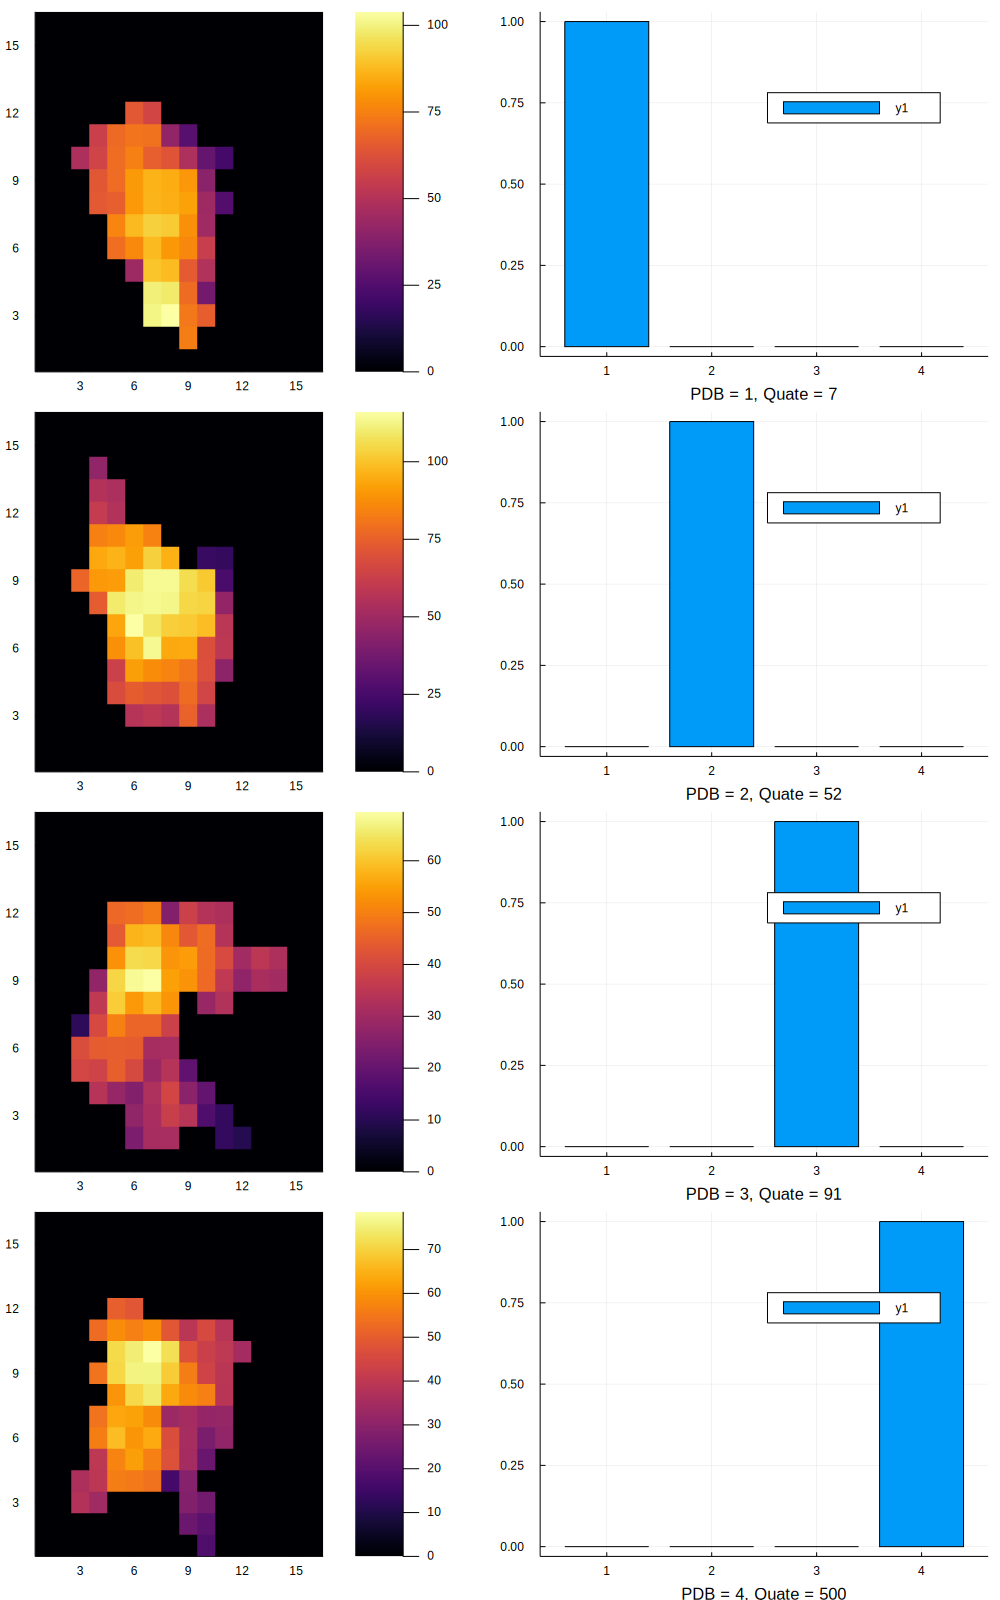

In [2]:
function BioAFM_QD_FFT(observedAfm, pdbList, quateList, sigma)::BioAFMResult
    imgH, imgW = size(observedAfm)
    pdbNum = size(pdbList, 1)
    quateNum = size(quateList, 1)
    posteriors = Float64[]
    mostPlausible = Float64(0)
    mostPlausiblePDB = Int(0)
    mostPlausibleQuate = Int(0)

    for pdbId in 1:pdbNum
        sumPlausible = Float64(0)
        for quateId in 1:quateNum
            pdbRotated = MDToolbox.rotate(pdbList[pdbId], quateList[quateId, :])
            calculatedAfm = MDToolbox.afmize(pdbRotated, (150.0, 150.0), (imgH, imgW))
            
            nowPlausible = bayesEstimationWithFFTConvolution(observedAfm, calculatedAfm, sigma)

            sumPlausible += nowPlausible
            if mostPlausible < nowPlausible
                mostPlausible = nowPlausible
                mostPlausiblePDB = pdbId
                mostPlausibleQuate = quateId
            end
        end
        push!(posteriors, sumPlausible)
    end
    println(posteriors)
    posteriors ./= sum(posteriors)
    return BioAFMResult(posteriors, mostPlausiblePDB, mostPlausibleQuate)
end

quateList = DelimitedFiles.readdlm("../quaternion/QUATERNION_LIST_576_Orient")
pdbList = [MDToolbox.readpdb("../model/0000$(i).pdb") for i in 1:4]
MDToolbox.decenter!.(pdbList)
@load "./testCase/fileNameList.jld2" fileNameList

resultList = BioAFMResult[]
afmDatas = []

for fileName in fileNameList
    @load fileName afmData
    @time result = BioAFM_QD_FFT(afmData, pdbList, quateList, 10.0)
    push!(afmDatas, afmData)
    push!(resultList, result)
end

plotPredictResult(afmDatas, resultList)